In [1]:
ls

bioactivity.csv         chembl_28.fps               get_bioactivities.sql
checksums.txt           chembl_28.sdf               Makefile
chembl_28/              chembl_uniprot_mapping.txt  README.md
chembl_28_chemreps.txt  download.sh                 tSNE_by_organism.ipynb


# Example of interaction with database

In [2]:
# %%time

# import pandas as pd
# import sqlite3

# # Read sqlite query results into a pandas DataFrame
# con = sqlite3.connect("chembl_28.db")
# activities = pd.read_sql_query("SELECT * from activities", con)
# activity_properties = pd.read_sql_query("SELECT * from activity_properties", con)

# # do stuff with the `activities` table as if it was a usual pandas dataframe

# con.close()

# Normal csv-based workflow

In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv("bioactivity.csv")
df.shape

(2466539, 10)

In [4]:
%%time

import numpy as np
from collections import defaultdict

cols = ['compound_chembl_id','target_chembl_id','pchembl_value']
d = defaultdict(lambda: [])
N = 2_000_000

for _, cmpd, target, pchembl in df[cols].sample(n=N).itertuples():
    if not np.isnan(pchembl):
        d[(cmpd, target)].append(pchembl)

CPU times: user 4.16 s, sys: 40.7 ms, total: 4.2 s
Wall time: 4.2 s


In [5]:
# we'll need this one later
sample_proteins = ["CHEMBL1798", "CHEMBL4330", "CHEMBL6166"]

for _, cmpd, target, pchembl in df[
    (df["target_chembl_id"] == sample_proteins[0])
    | (df["target_chembl_id"] == sample_proteins[1])
    | (df["target_chembl_id"] == sample_proteins[2])
][cols].itertuples():
    if not np.isnan(pchembl):
        d[(cmpd, target)].append(pchembl)

In [6]:
print(f"Unique compounds: {len(set([elem[0] for elem in d]))}")
print(f"Unique targets: {len(set([elem[1] for elem in d]))}")

Unique compounds: 268449
Unique targets: 5034


# Transform into sparse matrix

In [7]:
unique_compounds = set([elem[0] for elem in d])
unique_targets = set([elem[1] for elem in d])

unique_compounds = {elem: idx for idx, elem in enumerate(unique_compounds)}
unique_targets = {elem: idx for idx, elem in enumerate(unique_targets)}

In [8]:
# we'll need this one later
for protein in sample_proteins:
    if protein not in unique_targets:
        raise ValueError(
            f"Protein {protein} is not yet in `bioactivity.csv`, try later"
        )

In [9]:
from scipy.sparse import csr_matrix, dok_matrix

tar_shape, cmp_shape = len(unique_targets), len(unique_compounds)
m = dok_matrix((tar_shape, cmp_shape))

for (cmp, tar), pk in d.items():
    cmp_id = unique_compounds[cmp]
    tar_id = unique_targets[tar]
    m[tar_id, cmp_id] = np.mean(
        np.array(pk)
    )  # because array can contain multiple values for pchembl

In [10]:
m = csr_matrix(m)
m

<5034x268449 sparse matrix of type '<class 'numpy.float64'>'
	with 489617 stored elements in Compressed Sparse Row format>

# Do truncated SVD

In [11]:
%%time

from sklearn.decomposition import  TruncatedSVD

svd = TruncatedSVD(n_components=2048, n_iter=10, random_state=42)
target_fingerprints = svd.fit_transform(m)

print(svd.explained_variance_ratio_.sum())

0.9836272798563337


## And get fingerprints back

In [12]:
target_fps = {}
for target, target_id in unique_targets.items():
    target_fp = target_fingerprints[target_id]
    target_fps[target] = target_fp

# Let's compare fingerprints of some proteins

In [13]:
cltr1, cltr2, map4k4 = (
    target_fps["CHEMBL1798"],
    target_fps["CHEMBL4330"],
    target_fps["CHEMBL6166"],
)

In [14]:
np.abs(cltr1 - cltr2).sum()

553.0222726105527

In [15]:
np.abs(cltr1 - map4k4).sum()

1745.399331461951

In [16]:
np.abs(cltr2 - map4k4).sum()

1417.2147024311464

That's pretty cool: cltr1 and cltr2 are homologos (Cysteinyl leukotriene receprots 1 and 2, respectively), whereas map4k4 (a kinase) is roughly unrelated to them -- and the fingerprints show that, although they are unaware of the sequences themselves.

# Let's visualize distribution by organism using tSNE

## Map organisms with fingerprints

In [17]:
orgs = {}
for _, target, organism in df[["target_chembl_id", "organism"]].itertuples():
    orgs[target] = organism

In [18]:
%%time

X = []

targets, organisms = [], []
for target, fp in list(target_fps.items()):
    organism = orgs[target]
    X.append(fp)
    targets.append(target)
    organisms.append(organism)
    
X = np.array(X)

CPU times: user 17.1 ms, sys: 404 µs, total: 17.5 ms
Wall time: 16.7 ms


In [19]:
X.shape

(5034, 2048)

## tSNE itself

In [20]:
%%time

 from sklearn.manifold import TSNE

X_embed = TSNE(n_components=2).fit_transform(X)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

/home/marinegor/apps/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## filter results -- we want only organisms with high number of targets

In [27]:
from collections import Counter

freq_threshold = 100
cnt = 0
rv = []

for key, freq in Counter(organisms).items():
    if freq >= freq_threshold:
        cnt += 1
        rv.append(key)

In [28]:
rv  # <--- that's where are the targets

['Homo sapiens', 'Rattus norvegicus', 'Mus musculus', 'Bos taurus']

In [29]:
idx_sel = [key in rv for key in organisms]

In [30]:
X_embed_filtered = X_embed[idx_sel]
hue = np.array(organisms)[idx_sel]

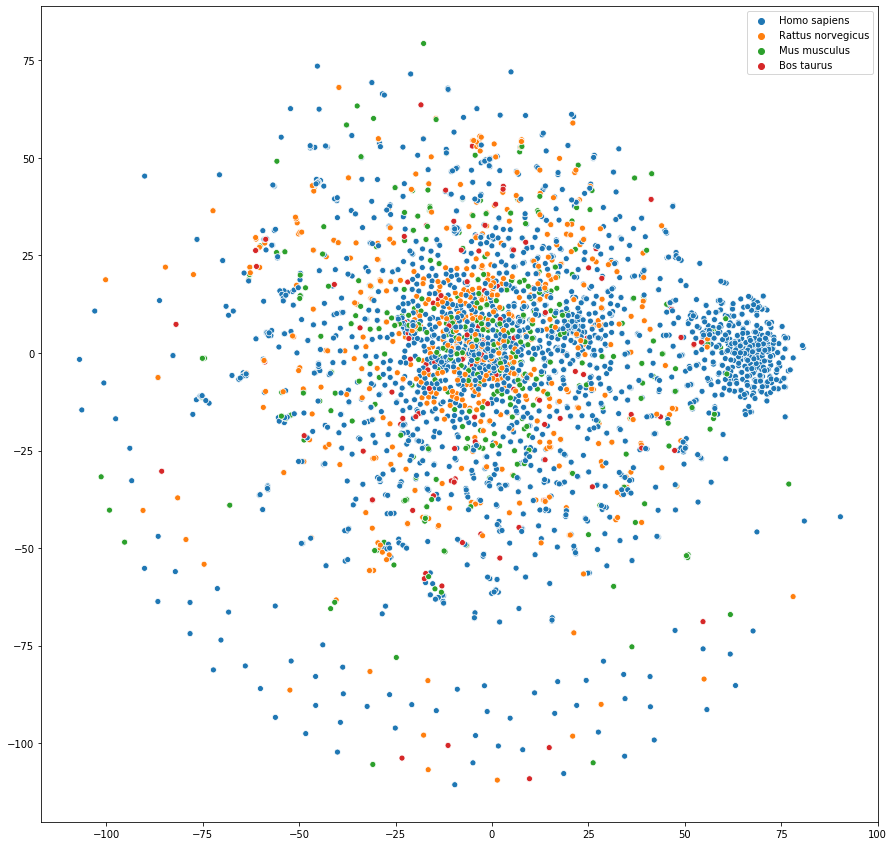

In [31]:
plt.rcParams["figure.figsize"] = (15, 15)

sns.scatterplot(
    X_embed_filtered[:, 0], X_embed_filtered[:, 1], hue=hue,
)

That doesn't show any separation -- but we didn't expect that, did we?